<a href="https://colab.research.google.com/github/syahvan/nvidia-stock-time-series/blob/main/NVIDIA-Stock-Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NVIDIA Stock Price Prediction

## Load Library

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Load Data

In [10]:
# Ambil data dari Yahoo Finance
stock_data = yf.download('NVDA',  period="max")
stock_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000
...,...,...,...,...,...,...
2024-07-02,121.129997,123.410004,121.029999,122.669998,122.669998,218374000
2024-07-03,121.660004,128.279999,121.360001,128.279999,128.279999,215749000
2024-07-05,127.379997,128.850006,125.680000,125.830002,125.830002,214176700


## Data Preprocessing

In [11]:
# Buat indeks tanggal lengkap dari tanggal awal hingga tanggal akhir (termasuk akhir pekan)
full_date_range = pd.bdate_range(start='1999-1-22', end='2024-7-9', freq='D')

# Reindeks data saham dengan indeks tanggal lengkap
stock_data = stock_data.reindex(full_date_range)

# Isi nilai-nilai yang hilang dengan harga penutup hari sebelumnya
stock_data = stock_data.fillna(method='ffill')

stock_data

,Open,High,Low,Close,Adj Close,Volume
1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2.714688e+09
1999-01-23,0.043750,0.048828,0.038802,0.041016,0.037621,2.714688e+09
1999-01-24,0.043750,0.048828,0.038802,0.041016,0.037621,2.714688e+09
1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,5.104800e+08
1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,3.432000e+08
...,...,...,...,...,...,...
2024-07-05,127.379997,128.850006,125.680000,125.830002,125.830002,2.141767e+08
2024-07-06,127.379997,128.850006,125.680000,125.830002,125.830002,2.141767e+08
2024-07-07,127.379997,128.850006,125.680000,125.830002,125.830002,2.141767e+08
2024-07-08,127.489998,130.770004,127.040001,128.199997,128.199997,2.376773e+08


In [12]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9301 entries, 1999-01-22 to 2024-07-09
Freq: D
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       9301 non-null   float64
 1   High       9301 non-null   float64
 2   Low        9301 non-null   float64
 3   Close      9301 non-null   float64
 4   Adj Close  9301 non-null   float64
 5   Volume     9301 non-null   float64
dtypes: float64(6)
memory usage: 508.6 KB


In [13]:
stock_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [14]:
# Gunakan kolom `Close` dan `Date` saja
stock_data['Date'] = stock_data.index
stock_data = stock_data.reset_index(drop=True)
stock_data = stock_data[['Date', 'Close']]
stock_data.head()

,Date,Close
0,1999-01-22,0.041016
1,1999-01-23,0.041016
2,1999-01-24,0.041016
3,1999-01-25,0.045313
4,1999-01-26,0.041797


In [15]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9301 entries, 0 to 9300
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9301 non-null   datetime64[ns]
 1   Close   9301 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 145.5 KB


## Time Series Plot

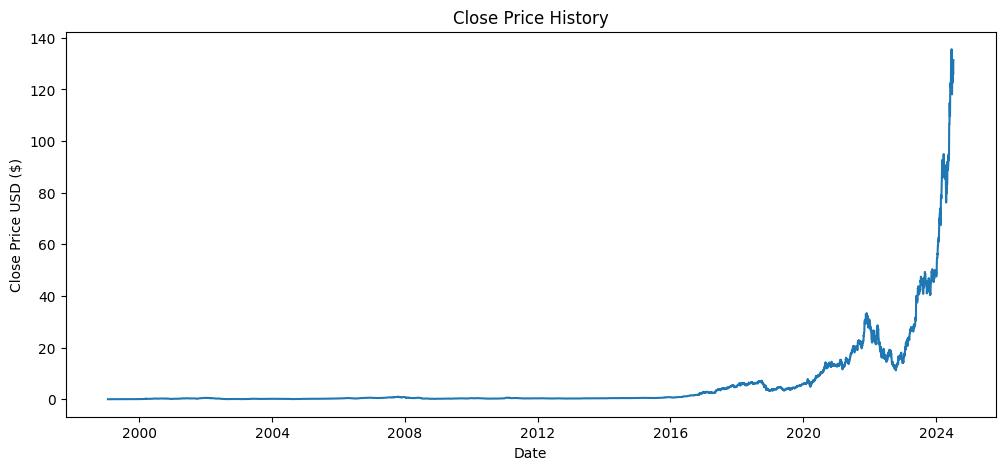

In [16]:
plt.figure(figsize=(12,5))
plt.title('Close Price History')
plt.plot(stock_data['Date'],stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

## Modelling

In [17]:
date = stock_data['Date'].values
close = stock_data['Close'].values

# Normalisasi data
min_max_scaler = MinMaxScaler()
close_scale = min_max_scaler.fit_transform(close.reshape(-1,1))

# Train-Valid Split
train_date, valid_date, train_close, valid_close = train_test_split(date, close_scale, test_size=0.2 , shuffle=False)

# Menampilkan ukuran data train dan data test
print("Data Train Size:", len(train_close))
print("Data Valid Size:", len(valid_close))

Data Train Size: 7440
Data Valid Size: 1861


In [18]:
# Mengubah dataset menjadi format yang dapat diterima model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(train_close, window_size=60, batch_size=128, shuffle_buffer=1000)
val_set = windowed_dataset(valid_close, window_size=60, batch_size=128, shuffle_buffer=1000)

In [19]:
# Membuat model
model = tf.keras.models.Sequential([
  LSTM(128, return_sequences=True, input_shape=(60, 1)),
  Dropout(0.2),
  LSTM(64, return_sequences=True),
  Dropout(0.2),
  Dense(30, activation="relu"),
  Dense(10, activation="relu"),
  Dense(1)
])

In [20]:
# Menentukan 10% skala data
min = close_scale.min()
print('Min Value:', str(min))

max = close_scale.max()
print('Max value:', str(max))

x = (max - min) * (10/100)
print('10% skala data:', str(x))

Min Value: 0.0
Max value: 0.9999999999999999
10% skala data: 0.09999999999999999


In [21]:
# Membuat fitur callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('mae')< x) and (logs.get('val_mae')< x)):
      self.model.stop_training = True
      print("\nMAE < 10% skala data, proses dihentikan!")
callbacks = myCallback()

In [22]:
# Menambahkan optimizer
optimizer = Adam(learning_rate=1.0000e-04)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [23]:
# Melakukan training data
history = model.fit(train_set, epochs=100, validation_data=val_set, callbacks=callbacks)

Epoch 1/100
58/58 [==============================] - 10s 44ms/step - loss: 3.5769e-05 - mae: 0.0040 - val_loss: 0.0320 - val_mae: 0.1692
Epoch 2/100
58/58 [==============================] - 2s 32ms/step - loss: 6.9768e-05 - mae: 0.0081 - val_loss: 0.0303 - val_mae: 0.1668
Epoch 3/100
58/58 [==============================] - 4s 64ms/step - loss: 6.9237e-05 - mae: 0.0082 - val_loss: 0.0284 - val_mae: 0.1638
Epoch 4/100
58/58 [==============================] - 2s 32ms/step - loss: 7.1161e-05 - mae: 0.0073 - val_loss: 0.0281 - val_mae: 0.1676
Epoch 5/100
58/58 [==============================] - 2s 30ms/step - loss: 4.9675e-05 - mae: 0.0068 - val_loss: 0.0231 - val_mae: 0.1471
Epoch 6/100
58/58 [==============================] - 2s 31ms/step - loss: 4.4471e-05 - mae: 0.0062 - val_loss: 0.0170 - val_mae: 0.1203
Epoch 7/100
56/58 [===========================>..] - ETA: 0s - loss: 2.7675e-05 - mae: 0.0049
MAE < 10% skala data, proses dihentikan!
58/58 [==============================] - 2s 30ms

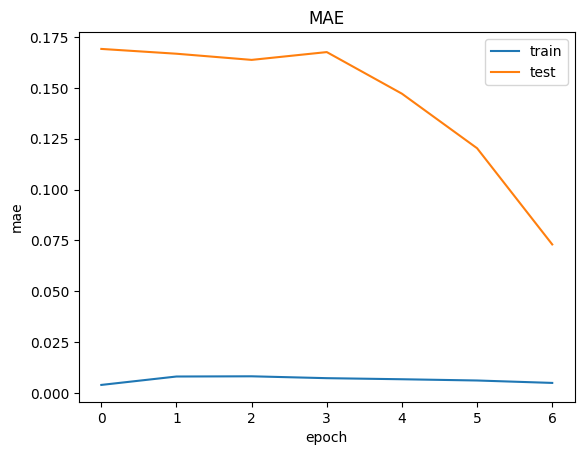

In [24]:
# Menampilkan plotting MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

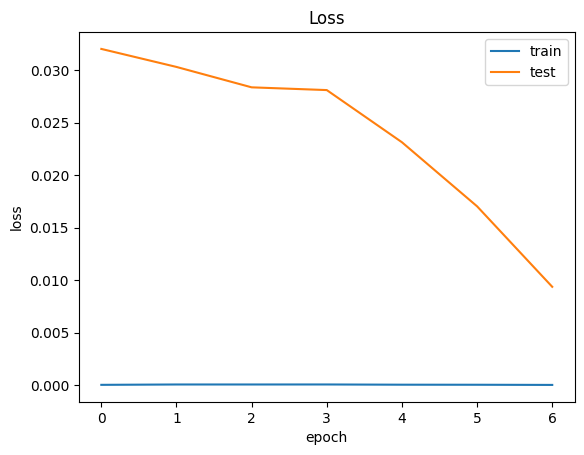

In [25]:
# Menampilkan plotting Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()